In [108]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [109]:
df = yf.download("MSFT", start="2023-01-01", end="2024-01-01", progress=False, auto_adjust=False)
df


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,,
2023-01-03,235.240021,239.580002,245.750000,237.399994,243.080002,25740000
2023-01-04,224.949875,229.100006,232.869995,225.960007,232.279999,50623400
2023-01-05,218.282837,222.309998,227.550003,221.759995,227.199997,39585600
2023-01-06,220.855392,224.929993,225.759995,219.350006,223.000000,43613600
2023-01-09,223.005737,227.119995,231.240005,226.410004,226.449997,27369800
...,...,...,...,...,...,...
2023-12-22,371.055695,374.579987,375.179993,372.709991,373.679993,17091100
2023-12-26,371.134949,374.660004,376.940002,373.500000,375.000000,12673100


In [110]:
df = df[["Adj Close"]].copy()
df.columns = ["MSFT"]

In [111]:
# daily return rate
df["MSFT_return"] = df["MSFT"].pct_change()
print(df.head())

                  MSFT  MSFT_return
Date                               
2023-01-03  235.240021          NaN
2023-01-04  224.949875    -0.043743
2023-01-05  218.282837    -0.029638
2023-01-06  220.855392     0.011785
2023-01-09  223.005737     0.009736


In [112]:
# SMA Cross
df['SMA_50'] = df['MSFT'].rolling(window=50).mean()
df['EMA_12'] = df['MSFT'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['MSFT'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_Hist'] = df['MACD'] - df['Signal_Line']
df['Volatility'] = df['MSFT'].pct_change().rolling(window=20).std() * np.sqrt(252)

df["SMA_short"] = df["MSFT"].rolling(window=5).mean()
df["SMA_long"] = df["MSFT"].rolling(window=20).mean()

df["Signal_TF"] = 0
df.loc[df["SMA_short"] > df["SMA_long"], "Signal_TF"] = 1
df.loc[df["SMA_short"] < df["SMA_long"], "Signal_TF"] = -1

# daily return of the strategies
df["Strategy_TF"] = df["Signal_TF"].shift(1) * df["MSFT_return"]

In [113]:
# Bollinger Bands(mean and sd)
rolling_mean = df["MSFT"].rolling(window=20).mean()
rolling_std = df["MSFT"].rolling(window=20).std()

# upper and lower
df["Upper"] = rolling_mean + 2 * rolling_std
df["Lower"] = rolling_mean - 2 * rolling_std

df['BB_Width'] = (df['Upper'] - df['Lower']) / df['SMA_long']

df["Signal_MR"] = 0
df.loc[df["MSFT"] > df["Upper"], "Signal_MR"] = -1
df.loc[df["MSFT"] < df["Lower"], "Signal_MR"] = 1

# daily return of the strategies
df["Strategy_MR"] = df["Signal_MR"].shift(1) * df["MSFT_return"]


In [114]:
# Z-score of the Mean reversion strategy
df["Z_score"] = (df["MSFT"] - rolling_mean) / rolling_std  # using rolling_mean and rolling_std from the Bollinger Bands
df["Signal_MR_Z"] = 0
df.loc[df["Z_score"] > 1, "Signal_MR_Z"] = -1  # High price deviation, short selling
df.loc[df["Z_score"] < -1, "Signal_MR_Z"] = 1   # Low price deviation, go long

# dynamic z-score threshold
dynamic_threshold = 1.5 + df['Volatility'] * 10
df.loc[df['Z_score'] > dynamic_threshold, 'Signal_MR_Z'] = -1
df.loc[df['Z_score'] < -dynamic_threshold, 'Signal_MR_Z'] = 1
df.loc[df['BB_Width'] > 0.1, 'Signal_MR_Z'] = 0 # bollinger width filtering
df["Strategy_MR_Z"] = df["Signal_MR_Z"].shift(1) * df["MSFT_return"]

# RSI filtering trend tracking strategy
delta = df["MSFT"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df["RSI"] = 100 - (100 / (1 + rs))

# Filter the original trend signal with RSI
df["Signal_TF_RSI"] = df["Signal_TF"]  # keep the original moving average signal
df.loc[(df["RSI"] > 70) | (df["RSI"] < 30), "Signal_TF_RSI"] = 0  # RSI Clear the position when overbought or oversold

overbought = 70 - df['Volatility'] * 100
oversold = 30 + df['Volatility'] * 100
df.loc[df['RSI'] > overbought, 'Signal_TF_RSI'] = 0
df.loc[df['RSI'] < oversold, 'Signal_TF_RSI'] = 0

df.loc[(df['MACD'] < df['Signal_Line']), 'Signal_TF_RSI'] = 0

df["Strategy_TF_RSI"] = df["Signal_TF_RSI"].shift(1) * df["MSFT_return"]

In [115]:
def evaluate_performance(returns):
    cumulative = (1 + returns).cumprod()
    ann_return = returns.mean() * 252
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol
    max_dd = (cumulative / cumulative.cummax() - 1).min()
    
    return {
        "Annual Return": ann_return,
        "Volatility": ann_vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": max_dd
    }
# baseline
df["Strategy_BH"] = df["MSFT_return"].cumsum()

# Analysis of the dd period
def calculate_drawdown(cumulative_returns):
    return (cumulative_returns / cumulative_returns.cummax() - 1) * 100

cumulative_tf = (1 + df["Strategy_TF"].dropna()).cumprod()
cumulative_mr = (1 + df["Strategy_MR"].dropna()).cumprod()
drawdown_tf = calculate_drawdown(cumulative_tf)
drawdown_mr = calculate_drawdown(cumulative_mr)

print(f"Follow the maximum drawdown date of the trend: {drawdown_tf.idxmin()}, drawdown: {drawdown_tf.min():.2f}%")
print(f"The date of the maximum retracement in mean reversion: {drawdown_mr.idxmin()}, drawdown: {drawdown_mr.min():.2f}%")

perf_bh = evaluate_performance(df["MSFT_return"].dropna())
perf_tf = evaluate_performance(df["Strategy_TF"].dropna())
perf_tf_rsi = evaluate_performance(df["Strategy_TF_RSI"].dropna())
perf_mr = evaluate_performance(df["Strategy_MR"].dropna())
perf_mr_z = evaluate_performance(df["Strategy_MR_Z"].dropna())

performance_df = pd.DataFrame({
    "Buy & Hold": perf_bh,
    "Trend Following (SMA)": perf_tf,
    "Trend Following (RSI Filtered)": perf_tf_rsi,
    "Mean Reversion (Bollinger)": perf_mr,
    "Mean Reversion (Z-score)": perf_mr_z
}).T.round(6)
performance_df

Follow the maximum drawdown date of the trend: 2023-10-20 00:00:00, drawdown: -22.64%
The date of the maximum retracement in mean reversion: 2023-05-26 00:00:00, drawdown: -5.51%


,Annual Return,Volatility,Sharpe Ratio,Max Drawdown
Buy & Hold,0.496859,0.251204,1.977910,-0.129876
Trend Following (SMA),-0.013701,0.236396,-0.057958,-0.226396
Trend Following (RSI Filtered),-0.018817,0.034665,-0.542813,-0.038179
Mean Reversion (Bollinger),0.106543,0.101296,1.051795,-0.055080
Mean Reversion (Z-score),0.008561,0.138399,0.061858,-0.137838


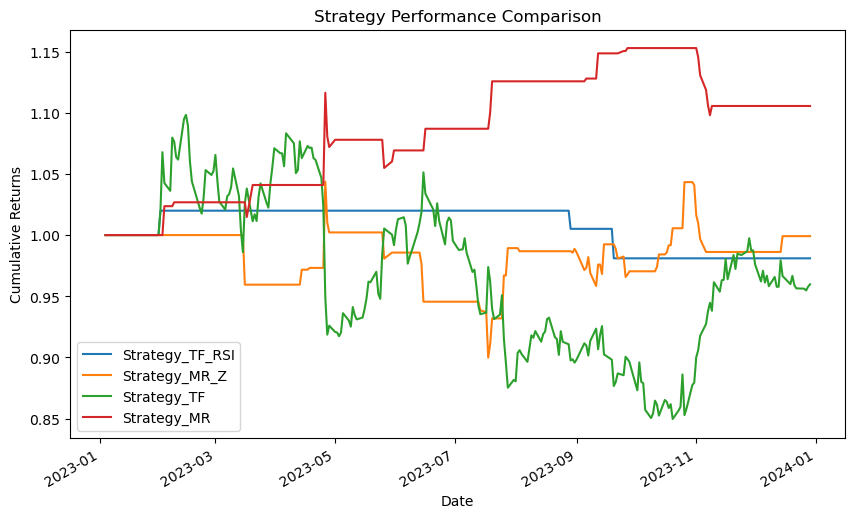

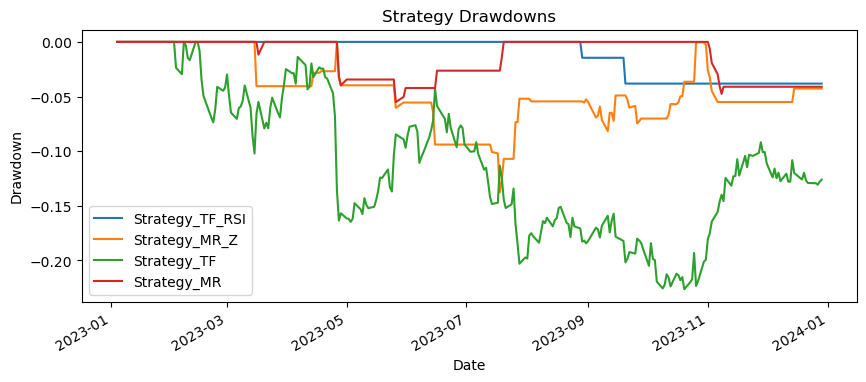

In [116]:
# Calculate and add more performance indicators
for strategy in performance_df.index:
    if strategy == 'Buy & Hold':
        col = 'Strategy_BH'
    elif 'Trend Following' in strategy:
        col = 'Strategy_TF_RSI' if 'RSI' in strategy else 'Strategy_TF'
    elif 'Mean Reversion' in strategy:
        col = 'Strategy_MR_Z' if 'Z-score' in strategy else 'Strategy_MR'
    else:
        continue
    
    if col not in df.columns:
        print(f"Warning: Column {col} not found in DataFrame")
        continue
    
    returns = df[col]
    
    # winning rate
    win_rate = len(returns[returns > 0]) / len(returns[returns != 0])
    performance_df.loc[strategy, 'Win Rate'] = round(win_rate, 4)
    
    # the profit and loss ratio
    winning_trades = returns[returns > 0]
    losing_trades = returns[returns < 0]
    
    avg_win = winning_trades.mean() if len(winning_trades) > 0 else 0
    avg_loss = losing_trades.mean() if len(losing_trades) > 0 else 0
    profit_ratio = abs(avg_win / avg_loss) if avg_loss != 0 else np.nan
    performance_df.loc[strategy, 'Profit Ratio'] = round(profit_ratio, 2)

available_columns = [col for col in ['MSFT_ret', 'Strategy_TF_RSI', 'Strategy_MR_Z', 'Strategy_TF', 'Strategy_MR'] 
                    if col in df.columns]

if len(available_columns) >= 2:
    (1 + df[available_columns]).cumprod().plot(figsize=(10,6))
    plt.title('Strategy Performance Comparison')
    plt.ylabel('Cumulative Returns')
    plt.show()
else:
    print("Not enough valid columns for performance comparison")

    
for col in ['Strategy_TF_RSI', 'Strategy_MR_Z', 'Strategy_TF', 'Strategy_MR']:
    if col in df.columns:
        cumulative = (1 + df[col]).cumprod()
        drawdown = (cumulative / cumulative.cummax() - 1)
        drawdown.plot(figsize=(10,4), label=col)
        
if any(col in df.columns for col in ['Strategy_TF_RSI', 'Strategy_MR_Z', 'Strategy_TF', 'Strategy_MR']):
    plt.title('Strategy Drawdowns')
    plt.ylabel('Drawdown')
    plt.legend()
    plt.show()
else:
    print("No valid strategy columns found for drawdown analysis")